In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import seaborn as sns

In [2]:
# sklearnデータセットに収録されたカルフォルニアの住宅価格のデータセットをロード
from sklearn.datasets import fetch_california_housing
housing_data = fetch_california_housing()  # インターネットにアクセスしてダウンロード

# 学習用データのデータフレームを作成
x = pd.DataFrame(housing_data["data"],columns=housing_data["feature_names"])
y = pd.DataFrame(housing_data["target"],columns=["target"])

# データフレームの形状と説明変数の列名を表示
print('feature shape:', x.shape, housing_data["feature_names"])
print('target shape:', y.shape)

feature shape: (20640, 8) ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target shape: (20640, 1)


In [3]:
## 欠損値の確認 (pandasのisnull関数を利用)
# any(axis=0) で各列に欠損値があるかを確認
print(x.isnull().any(axis=0))
print(y.isnull().any(axis=0))

MedInc        False
HouseAge      False
AveRooms      False
AveBedrms     False
Population    False
AveOccup      False
Latitude      False
Longitude     False
dtype: bool
target    False
dtype: bool


In [4]:
# データを学習用と検証用に分割 (test_sizeで検証データの比率を指定(0.0-1.0の間), random_stateは乱数シード)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
print(len(x_train), len(x_test), len(y_train), len(y_test)) # それぞれのデータ数を確認

15480 5160 15480 5160


In [5]:
# 学習データ(説明変数と応答変数)の相関行列を確認
train = pd.concat([x_train, y_train],axis=1,sort=False)
train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.124221,0.319823,-0.058308,0.004869,0.023474,-0.076846,-0.017789,0.689751
HouseAge,-0.124221,1.000000,-0.150428,-0.072774,-0.295488,0.015203,0.009088,-0.105493,0.105289
AveRooms,0.319823,-0.150428,1.000000,0.853619,-0.074164,-0.003943,0.108921,-0.031621,0.150691
AveBedrms,-0.058308,-0.072774,0.853619,1.000000,-0.066350,-0.005216,0.071617,0.008817,-0.041630
Population,0.004869,-0.295488,-0.074164,-0.066350,1.000000,0.077475,-0.105922,0.097999,-0.027025
AveOccup,0.023474,0.015203,-0.003943,-0.005216,0.077475,1.000000,0.005771,-0.000110,-0.021743
Latitude,-0.076846,0.009088,0.108921,0.071617,-0.105922,0.005771,1.000000,-0.925420,-0.138818
Longitude,-0.017789,-0.105493,-0.031621,0.008817,0.097999,-0.000110,-0.925420,1.000000,-0.051350
target,0.689751,0.105289,0.150691,-0.041630,-0.027025,-0.021743,-0.138818,-0.051350,1.000000


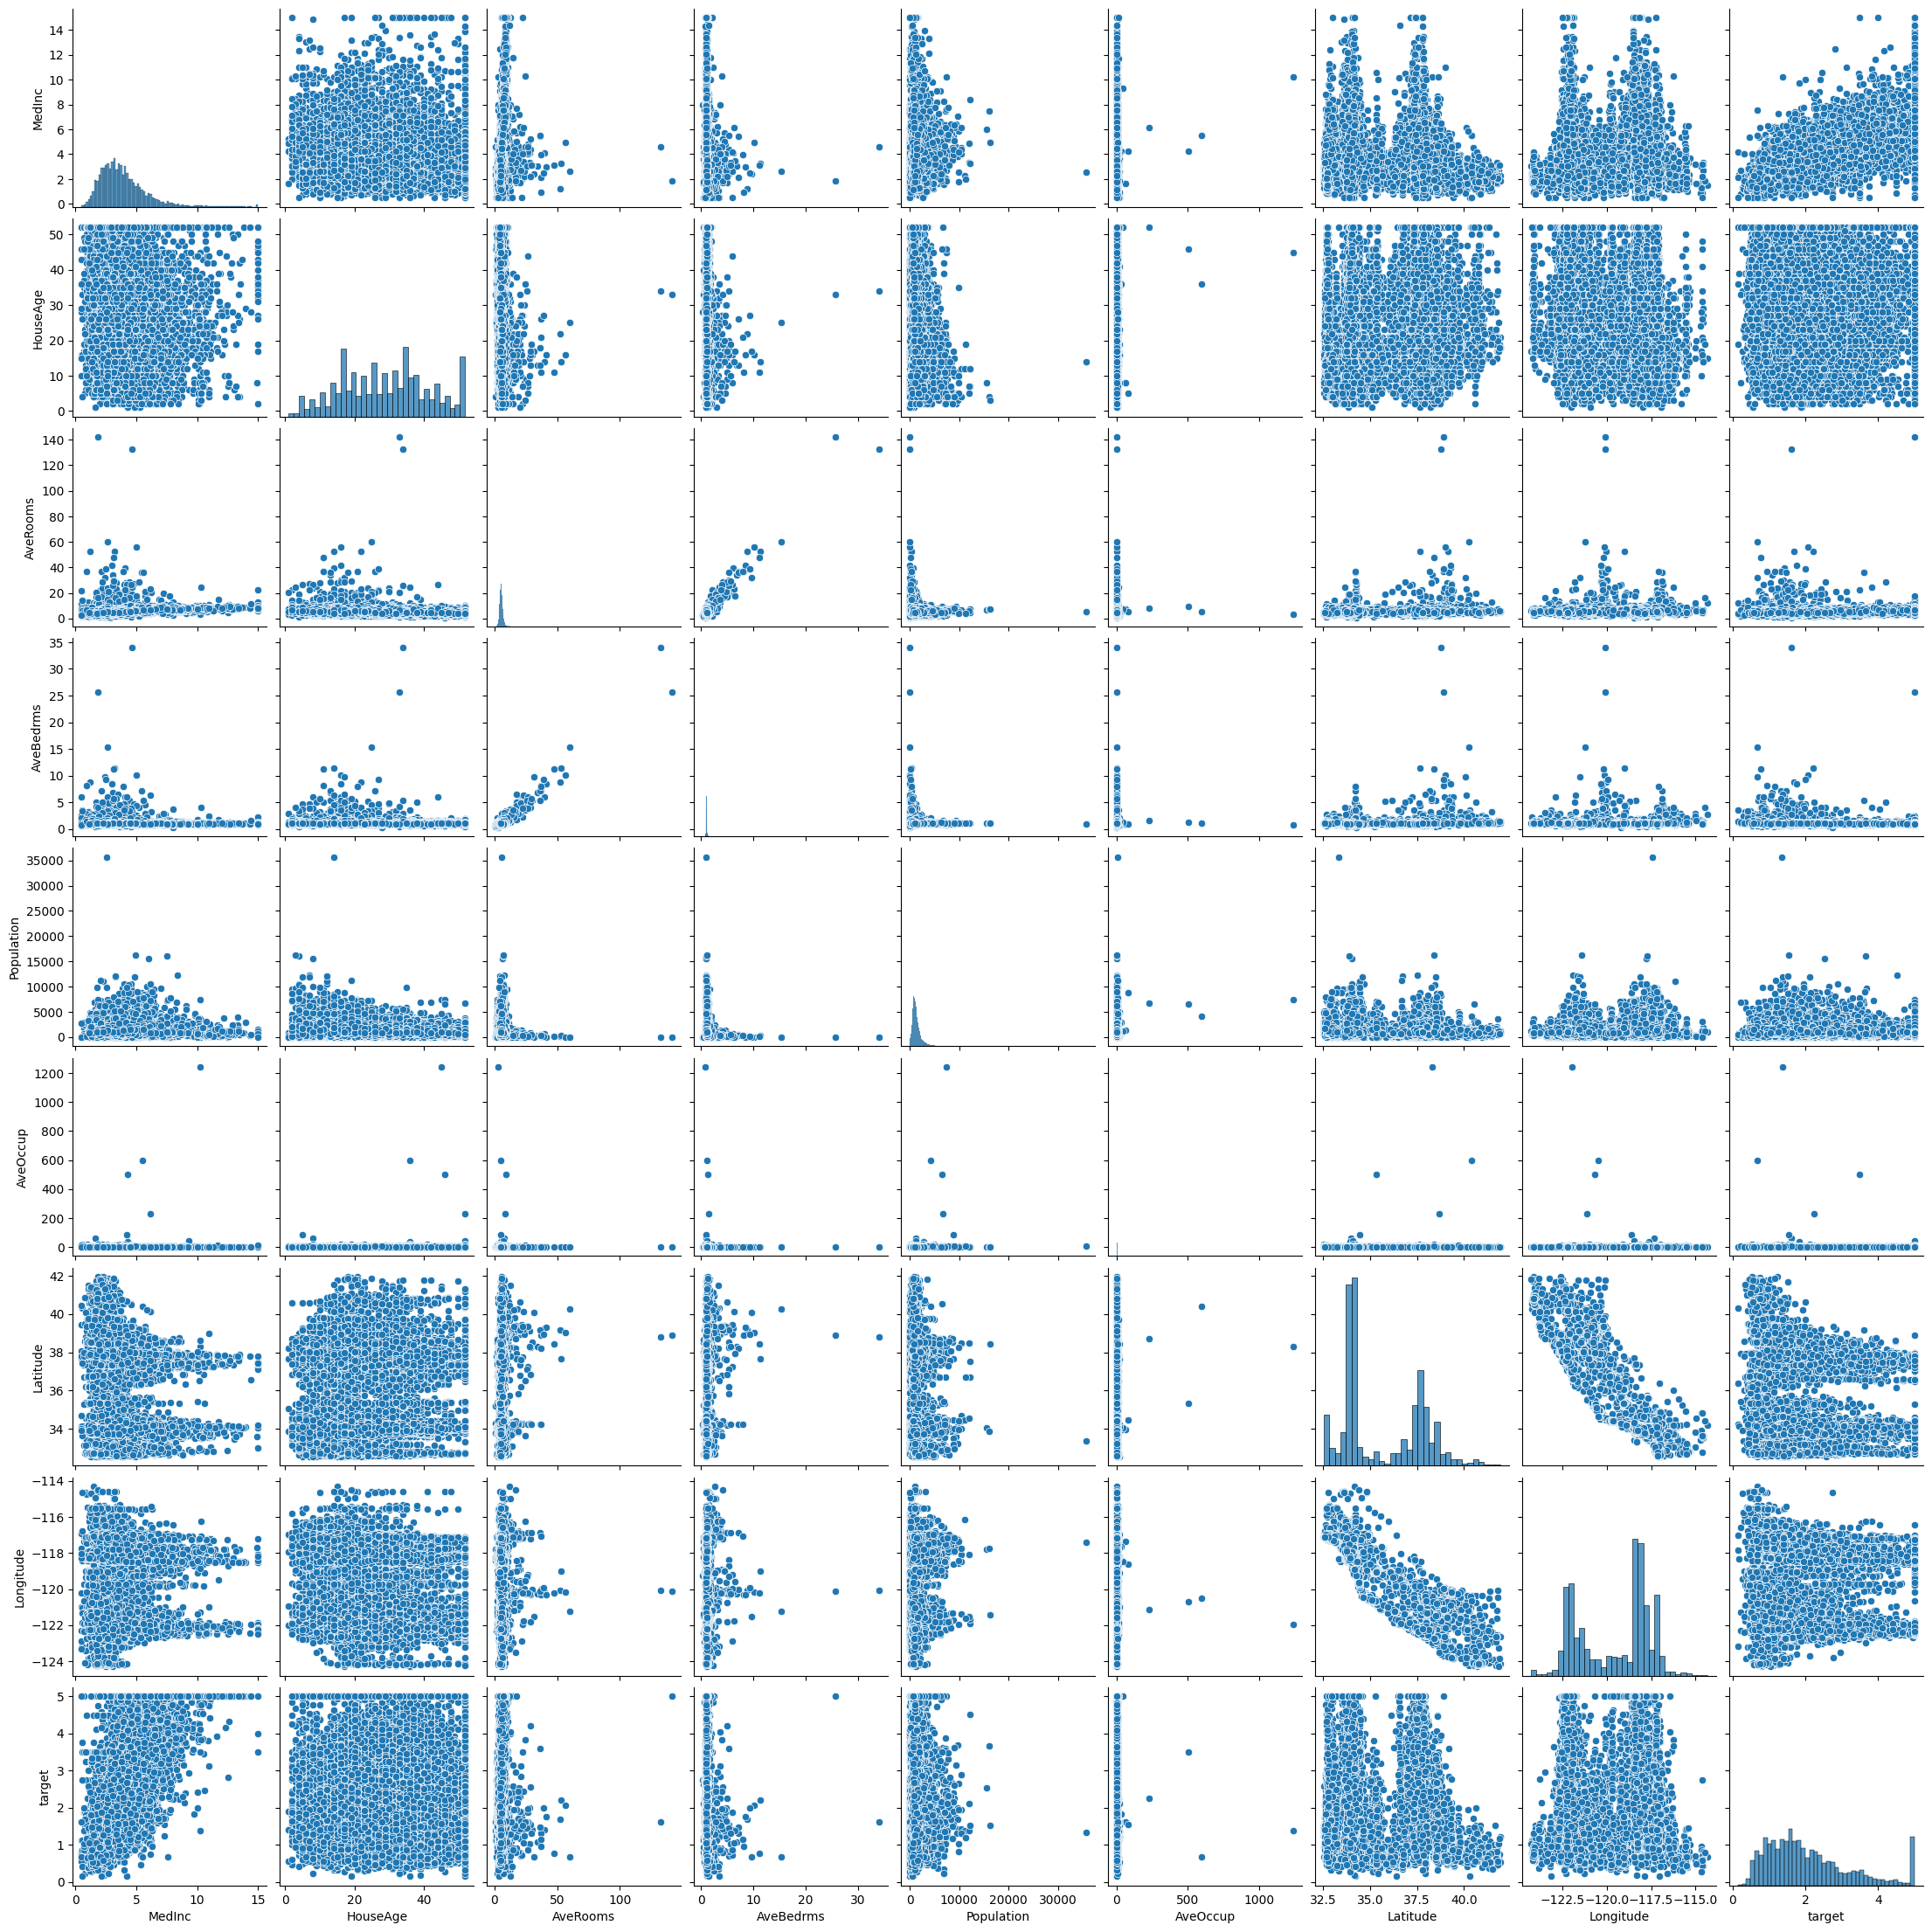

In [6]:
# 学習用データのペアプロットを表示
sns.pairplot(train)
plt.show()

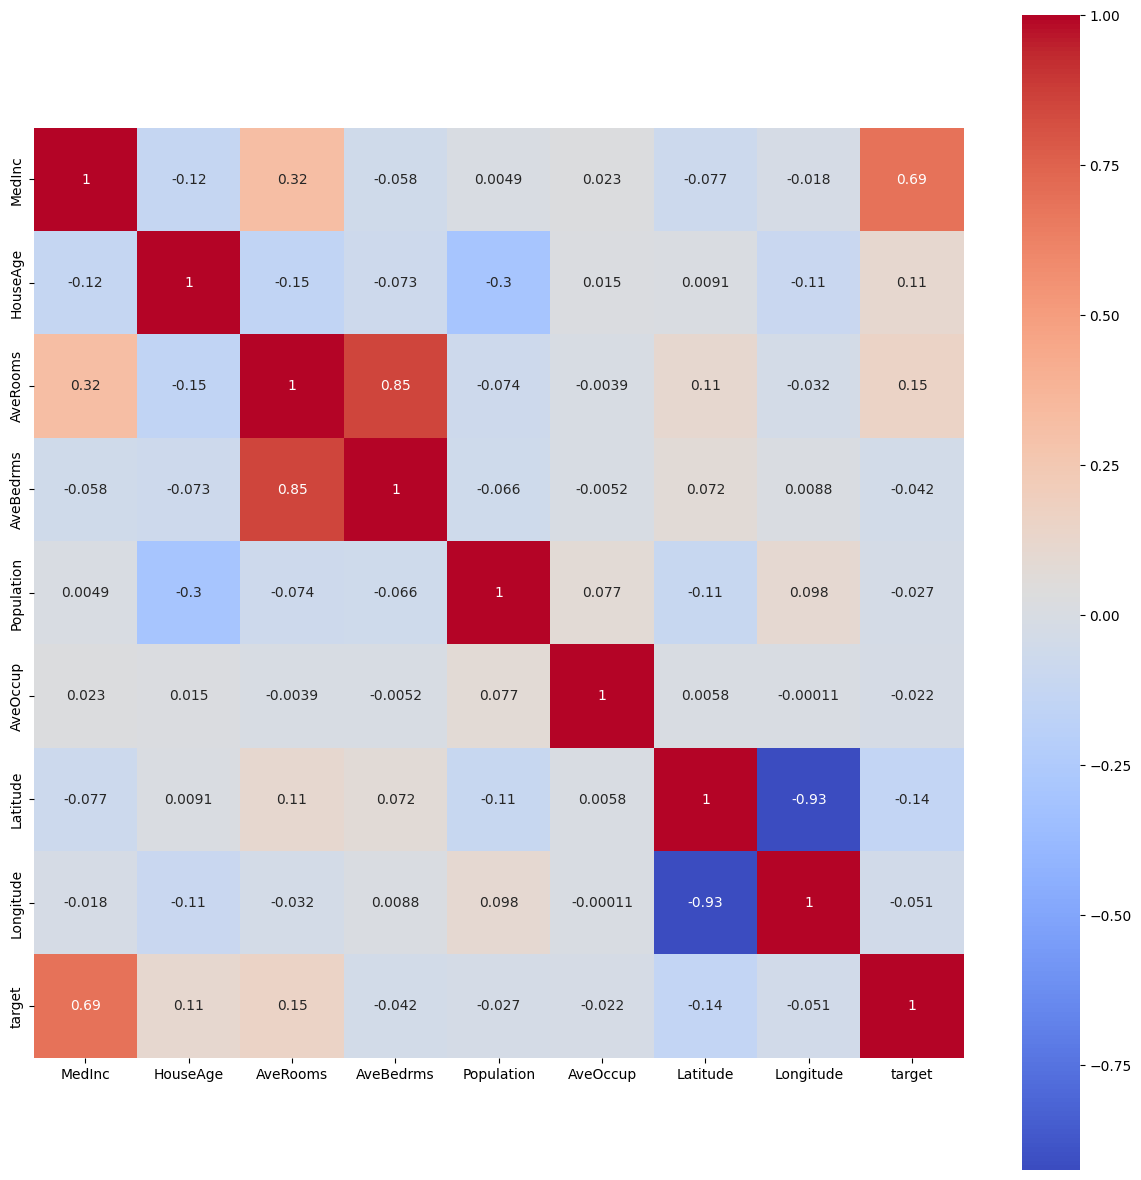

In [7]:
# 学習用データのヒートマップを表示
plt.rcParams['figure.figsize'] = (15.0, 15.0)
sns.heatmap(train.corr(), square=True, annot=True, cmap='coolwarm')
plt.show()

In [8]:
# 独立変数間の分散拡大要因を確認 (データサイエンス基礎 配布資料(第8回) 参照)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm

sm_model = sm.OLS(y_train, x_train)
result = sm_model.fit()
# print (result.summary())
num_cols = sm_model.exog.shape[1] # 説明変数の列数
vifs = [vif(sm_model.exog, i) for i in range(0, num_cols)]
print(pd.DataFrame(vifs, index=sm_model.exog_names, columns=['VIF']))

                   VIF
MedInc       11.451127
HouseAge      7.179175
AveRooms     44.612144
AveBedrms    41.666977
Population    2.974146
AveOccup      1.077422
Latitude    558.385057
Longitude   630.496962


In [9]:
# 回帰モデルを作成
model = LinearRegression()

# 回帰モデルを学習用データで学習
model.fit(x_train, y_train)

## 検証用データを利用してモデルを評価
# 学習したモデルを使い、検証用データから応答変数を予測
pred = model.predict(x_test)

# 平均絶対誤差、平均二乗誤差、決定係数を計算
print('平均絶対誤差', mean_absolute_error(y_pred=pred, y_true=y_test))
print('平均二乗誤差', mean_squared_error(y_pred=pred, y_true=y_test))
print('平均平方二乗誤差', math.sqrt(mean_squared_error(y_pred=pred, y_true=y_test)))
print('決定係数', model.score(x_test, y_test))
print('(参考) 学習データに対する決定係数', model.score(x_train, y_train))

平均絶対誤差 0.5351008445282477
平均二乗誤差 0.5356532845422556
平均平方二乗誤差 0.7318833817912903
決定係数 0.5929869285760101
(参考) 学習データに対する決定係数 0.6102859678113064


In [10]:
# sklearn の RFECV を使って変数を選択する
# RFECV : クロスバリデーションを行いながら説明変数の除外を実施
from sklearn.feature_selection import RFECV
import sklearn
rfecv = RFECV(estimator=LinearRegression(), cv=10, scoring="r2")
rfecv.fit(x_train.values, y_train)

# 選択された説明変数
print('all: ', x_train.columns.values)
print('selected:', x_train.columns[rfecv.support_].values)

# 選択された説明変数のデータフレームを作成
x_train_mod = x_train[x_train.columns[rfecv.support_]]
x_test_mod = x_test[x_test.columns[rfecv.support_]]

all:  ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude']
selected: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'AveOccup' 'Latitude'
 'Longitude']


In [11]:
# 修正版の回帰モデルを作成
model_mod = LinearRegression()

# 修正版の回帰モデルを変数選択後の学習用データで学習
model_mod.fit(x_train_mod, y_train)

## 検証用データを利用してモデルを評価
# 学習したモデルを使い、検証用データから応答変数を予測
pred = model_mod.predict(x_test_mod)

# 平均絶対誤差、平均二乗誤差、決定係数を計算
print('平均絶対誤差', mean_absolute_error(y_pred=pred, y_true=y_test))
print('平均二乗誤差', mean_squared_error(y_pred=pred, y_true=y_test))
print('平均平方二乗誤差', math.sqrt(mean_squared_error(y_pred=pred, y_true=y_test)))
print('決定係数', model_mod.score(x_test_mod, y_test))
print('(参考) 学習データに対する決定係数', model_mod.score(x_train_mod, y_train))

平均絶対誤差 0.5351296356117629
平均二乗誤差 0.5356542782475178
平均平方二乗誤差 0.731884060659554
決定係数 0.5929861735147746
(参考) 学習データに対する決定係数 0.6102683342721889


In [12]:
sm_model = sm.OLS(y_train, x_train_mod)
result = sm_model.fit()
# print (result.summary())
num_cols = sm_model.exog.shape[1] # 説明変数の列数
vifs = [vif(sm_model.exog, i) for i in range(0, num_cols)]
print(pd.DataFrame(vifs, index=sm_model.exog_names, columns=['VIF']))

                  VIF
MedInc      11.451085
HouseAge     6.444658
AveRooms    44.473953
AveBedrms   41.650397
AveOccup     1.069050
Latitude   548.600389
Longitude  600.628716
